# Generated Content Detector Project: AI generated photos vs real photos
## Pytorch CNN model - Version 5


### Import libraries

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
print(torch.cuda.is_available())

True


### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Determine System Device to optimize performance: CPU or CUDA (VRAM) Checker

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


### Image Dataset Preparation with PyTorch
##### - Training Data: 7,000 images (3500 AI + 3500 real) - 70%
##### - Testing Data: 2,000 images (1000 AI + 1000 real) - 20%
##### - Testing Data: 1,000 images (500 AI + 500 real) - 10%

In [ ]:
# Measure the time taken for the cell execution:
%%time

# Set up image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset from the specified directory
dataset = datasets.ImageFolder("/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_cnn_final_version/AI-face-detection-Dataset-v3/", transform=transform)

# dataset.class_to_idx → {'ai': 0, 'real': 1}

# Split by class (real + ai separately)
indices_real = [i for i, (_, label) in enumerate(dataset) if label == dataset.class_to_idx["real_color"]]
indices_ai   = [i for i, (_, label) in enumerate(dataset) if label == dataset.class_to_idx["AI"]]

# Train size 70%, Validation size 10%, Test size 20%
def split_class(indices, train_ratio=0.7, val_ratio=0.1):
    train_len = int(len(indices) * train_ratio)
    val_len = int(len(indices) * val_ratio)
    return indices[:train_len], indices[train_len:train_len + val_len], indices[train_len + val_len:]

train_real, val_real, test_real = split_class(indices_real)
train_ai, val_ai, test_ai = split_class(indices_ai)

# Combine training, validation, and testing indices
train_indices = train_real + train_ai
val_indices = val_real + val_ai
test_indices = test_real + test_ai

# Prepare subsets for training, validation, and testing
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Create data loaders for batch processing
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)  # Validation loader
testloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

# Retrieve class names
classes = dataset.classes   # ['ai', 'real']

# Output the number of samples in training, validation, and testing datasets
print("Train samples:", len(train_indices))
print("Validation samples:", len(val_indices))
print("Test samples:", len(test_indices))
print("Classes:", classes)

Train samples: 6996
Validation samples: 998
Test samples: 2002
Classes: ['AI', 'real_color']
CPU times: user 11min 25s, sys: 6.01 s, total: 11min 31s
Wall time: 44min 45s


### Display Randomly Selected Images with Classifications from the Trained Model

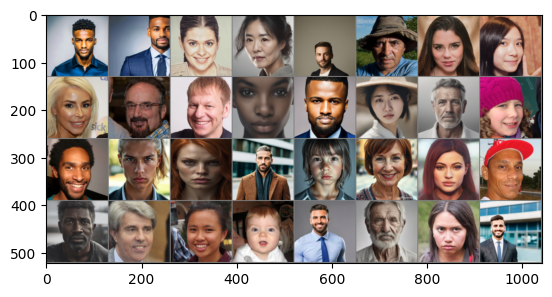

Train Labels: AI    AI    real_color AI    AI    real_color AI    real_color


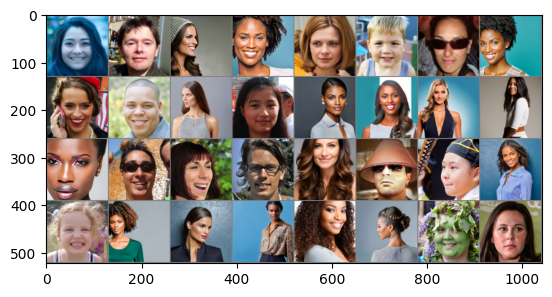

Validation Labels: real_color real_color AI    AI    real_color real_color real_color AI   


In [ ]:
# Functions to display an image
batch_size = 8
def imshow(img):
    img = img / 2 + 0.5     # unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Fetch some random training images
dataiter_train = iter(trainloader)
images_train, labels_train = next(dataiter_train)

# Display the training images
imshow(torchvision.utils.make_grid(images_train))

# Print the corresponding training labels
print('Train Labels: ' + ' '.join(f'{classes[labels_train[j]]:5s}' for j in range(batch_size)))

# Fetch some random validation images
dataiter_val = iter(valloader)
images_val, labels_val = next(dataiter_val)

# Display the validation images
imshow(torchvision.utils.make_grid(images_val))

# Print the corresponding validation labels
print('Validation Labels: ' + ' '.join(f'{classes[labels_val[j]]:5s}' for j in range(batch_size)))

### Define a Convolutional Neural Network (CNN) for Image Classification
##### This code implements a convolutional neural network (CNN) class named Net, featuring two convolutional layers with pooling, followed by three fully connected layers. It is designed for binary image classification, effectively modeling the forward pass to process input images and output class predictions.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # First convolutional layer
        self.pool = nn.MaxPool2d(2, 2) # Max pooling layer
        self.conv2 = nn.Conv2d(6, 16, 5) # Second convolutional layer
        # Flattened size: 16 channels * 29 * 29 (for fully connected layer)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)  # First fully connected layer
        self.fc2 = nn.Linear(120, 84) # Second fully connected layer
        self.fc3 = nn.Linear(84, 2)  # Output layer for 2 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # Apply first conv layer and pooling
        x = self.pool(F.relu(self.conv2(x))) # Apply second conv layer and pooling
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        x = F.relu(self.fc1(x)) # Forward pass through first fully connected layer
        x = F.relu(self.fc2(x)) # Forward pass through second fully connected layer
        x = self.fc3(x) # Output layer
        return x


# net = Net()             # Use this for CPU
net = Net().to(device)    # Move the model to GPU

### Define a Loss function and optimizer

In [ ]:
# Define the loss function for training
criterion = nn.CrossEntropyLoss() # This is used for multi-class classification

# Set up the optimizer for updating the model's parameters
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # Stochastic Gradient Descent with momentum

# Alternative optimizer (commented out): Adam optimizer for adaptive learning rate
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

### Training the Neural Network
##### This section of the code trains a neural network for image classification 100 epochs, calculating and recording the training loss at each epoch. The process utilizes a data loader to iterate through the training dataset, performs forward passes to compute outputs, calculates the loss using a defined criterion, performs backward passes to compute gradients, and updates the model weights using the specified optimizer.

##### Additionally, an early stopping mechanism is implemented, based on validation loss, to mitigate overfitting caused by high variance. This technique allows the model to terminate training when its performance on the validation set begins to degrade, preventing excessive fitting to the training data and improving generalization.


In [ ]:
# Measure the time taken for the cell execution:
%%time

train_losses = [] # Initialize a list to store training losses for each epoch
val_losses = []  # List to store validation losses
best_val_loss = float("inf") # Initialize best validation loss to infinity
patience = 8 # Number of epochs to wait before early stopping
epochs_no_improve = 0 # Counter for epochs without improvement in validation loss

# Loop through a specified number of epochs
for epoch in range(100):
    running_loss = 0.0  # Initialize cumulative loss for the current epoch

    # Iterate through the training data
    for i, data in enumerate(trainloader): # Iterate over the number of epochs
        inputs, labels = data  # Get the input images and their corresponding labels

        inputs = inputs.to(device)  # Move inputs to the device (GPU or CPU)
        labels = labels.to(device)  # Move labels to the device

        optimizer.zero_grad()  # Clear previous gradients

        outputs = net(inputs)  # Forward pass: compute the model's predictions

        loss = criterion(outputs, labels)  # Compute the training loss

        loss.backward()  # Backward pass: compute gradients
        optimizer.step()  # Update model parameters

        running_loss += loss.item()  # Accumulate the training loss

    epoch_loss = running_loss / len(trainloader)  # Average loss for the epoch
    train_losses.append(epoch_loss)  # Store the epoch loss
    print(f"Epoch {epoch+1}, Training loss: {epoch_loss:.4f}")  # Print the training loss for the current epoch

    # Validation phase
    net.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0  # Initialize cumulative validation loss

    with torch.no_grad():  # Disable gradient calculation for validation
        for data in valloader:
            inputs, labels = data  # Get the validation images and labels
            inputs = inputs.to(device)  # Move inputs to the device
            labels = labels.to(device)  # Move labels to the device

            outputs = net(inputs)  # Forward pass: compute predictions
            loss = criterion(outputs, labels)  # Compute validation loss
            val_running_loss += loss.item()  # Accumulate validation loss

    val_epoch_loss = val_running_loss / len(valloader)  # Average validation loss for the epoch
    val_losses.append(val_epoch_loss)  # Store the validation loss
    print(f"Epoch {epoch+1}, Validation loss: {val_epoch_loss:.4f}")  # Print validation loss

    if val_epoch_loss < best_val_loss: # If the current validation loss is the best
        best_val_loss = val_epoch_loss # Update best validation loss
        epochs_no_improve = 0 # Reset the no-improve counter
        torch.save(net.state_dict(), "best_model.pth") # Save the best model
    else: # If the validation loss did not improve
        epochs_no_improve += 1 # Increment the no-improve counter
        if epochs_no_improve >= patience: # Check if patience limit is reached
            print("Early stopping") # Indicate early stopping condition met
            break  # Exit the training loop if no improvement

print("Finished Training")  # Indicate the training process is complete


Epoch 1, Training loss: 0.5199
Epoch 1, Validation loss: 0.3534
Epoch 2, Training loss: 0.3058
Epoch 2, Validation loss: 0.2365
Epoch 3, Training loss: 0.2533
Epoch 3, Validation loss: 0.2516
Epoch 4, Training loss: 0.2157
Epoch 4, Validation loss: 0.1974
Epoch 5, Training loss: 0.1790
Epoch 5, Validation loss: 0.1480
Epoch 6, Training loss: 0.1522
Epoch 6, Validation loss: 0.1054
Epoch 7, Training loss: 0.1318
Epoch 7, Validation loss: 0.1631
Epoch 8, Training loss: 0.1168
Epoch 8, Validation loss: 0.0955
Epoch 9, Training loss: 0.0976
Epoch 9, Validation loss: 0.0964
Epoch 10, Training loss: 0.0862
Epoch 10, Validation loss: 0.1000
Epoch 11, Training loss: 0.0750
Epoch 11, Validation loss: 0.1323
Epoch 12, Training loss: 0.0677
Epoch 12, Validation loss: 0.1098
Epoch 13, Training loss: 0.0578
Epoch 13, Validation loss: 0.1147
Epoch 14, Training loss: 0.0516
Epoch 14, Validation loss: 0.0931
Epoch 15, Training loss: 0.0426
Epoch 15, Validation loss: 0.1326
Epoch 16, Training loss: 0.0

### Visualizing Training Results:
###### The training loss graph indicates that the model has effectively learned from the training data, as evidenced by the steady decline in training loss. The validation loss shows a similar downward trend initially, stabilizing afterward, which suggests that the model performs well on unseen data. The implementation of early stopping has prevented overfitting, allowing the model to achieve a balance where its performance on the validation set remains strong without excessive tailoring to the training dataset. Overall, the close alignment between the training and validation loss lines reflects good generalization capabilities of the model.

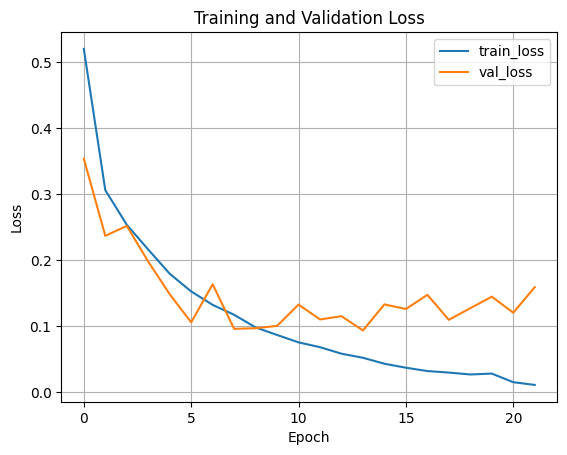

In [ ]:
def plot_history(train_losses, val_losses):
    plt.figure()  # Create a new figure for the plot
    plt.plot(train_losses, label="train_loss")  # Plot the training losses
    plt.plot(val_losses, label="val_loss")      # Plot the validation losses
    plt.xlabel("Epoch")                         # Label for the x-axis
    plt.ylabel("Loss")                          # Label for the y-axis
    plt.title("Training and Validation Loss")   # Title of the plot
    plt.grid(True)                              # Add a grid for better readability
    plt.legend()                                # Show the legend on the plot
    plt.show()                                  # Display the plot

# Check if 'train_losses' and 'val_losses' exist and are not empty before plotting
if 'train_losses' in globals() and train_losses and 'val_losses' in globals() and val_losses:
    plot_history(train_losses, val_losses)  # Call the plotting function with training and validation losses
else:
    print("Error: 'train_losses' or 'val_losses' not found or is empty. Please run the training cell first.")  # Error message if the lists are unavailable


### Saving the Trained Model


In [ ]:
PATH = '/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_cnn_final_version/ai_real_net_v6.pth'
torch.save(net.state_dict(), PATH)

### Testing the Network on Test Data
###### The code initializes a test data iterator, retrieves a batch of test images and their labels, and displays the images while printing the corresponding ground truth labels.


Test Data Iterator: <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7ef7c6f83c50>


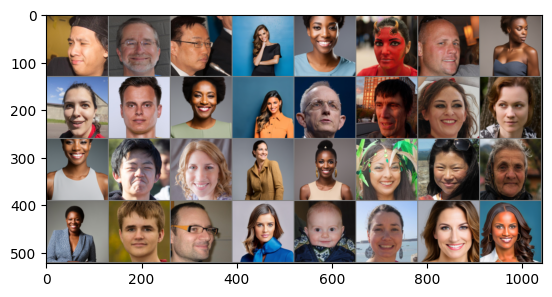

GroundTruth:  real_color real_color real_color AI    AI    real_color real_color AI   


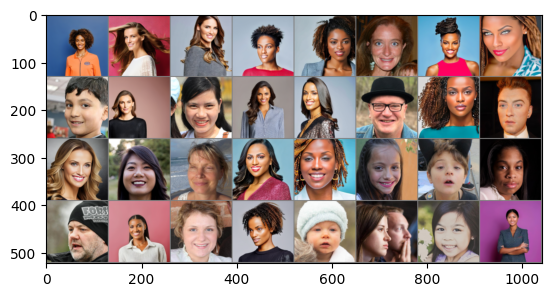

Validation GroundTruth:  AI    AI    AI    AI    AI    real_color AI    AI   


In [ ]:
# Test Data Visualization
dataiter_test = iter(testloader)  # Create an iterator for the test data loader
print("Test Data Iterator:", dataiter_test)  # Print the iterator object for reference
images_test, labels_test = next(dataiter_test)  # Get a batch of test images and their corresponding labels

# Display the test images using the defined imshow function
imshow(torchvision.utils.make_grid(images_test))

# Print the ground truth labels for the displayed test images
print('GroundTruth: ', ' '.join(f'{classes[labels_test[j]]:5s}' for j in range(8)))

# Optionally, visualize validation images
dataiter_val = iter(valloader)  # Create an iterator for the validation data loader
images_val, labels_val = next(dataiter_val)  # Get a batch of validation images and their corresponding labels

# Display the validation images using the defined imshow function
imshow(torchvision.utils.make_grid(images_val))

# Print the ground truth labels for the displayed validation images
print('Validation GroundTruth: ', ' '.join(f'{classes[labels_val[j]]:5s}' for j in range(8)))

### Loading the Saved Model and Summary of Architecture
##### The code loads the saved model and generates a summary of its architecture, revealing approximately 1.63 million trainable parameters with no non-trainable parameters. It details the output shapes for each layer, including two convolutional layers followed by pooling and three fully connected layers. This information is crucial for understanding the model's complexity and resource requirements, indicating its potential computational demands.

In [ ]:
# Define the path where the model is saved
PATH = '/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_cnn_final_version/ai_real_net_v6.pth'

# Initialize the neural network model
net = Net()

# Load the model's weights from the specified path
net.load_state_dict(torch.load(PATH, map_location=device))  # Specify map_location for compatibility

# Move the model to the appropriate device
net.to(device)

# Set the model to evaluation mode
net.eval()  # Important for layers like dropout and batch normalization if they are present

# Display a summary of the model architecture with the corrected input size
summary(net, (3, 128, 128))  # Display the model summary for input size of (3, 128, 128)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 124, 124]             456
         MaxPool2d-2            [-1, 6, 62, 62]               0
            Conv2d-3           [-1, 16, 58, 58]           2,416
         MaxPool2d-4           [-1, 16, 29, 29]               0
            Linear-5                  [-1, 120]       1,614,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 2]             170
Total params: 1,628,046
Trainable params: 1,628,046
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 1.39
Params size (MB): 6.21
Estimated Total Size (MB): 7.79
----------------------------------------------------------------


### Interpreting Model Outputs: Class Predictions
##### The model outputs represent the predicted class labels for the input images, demonstrating the network's classifications of each image. These predictions indicate the class to which the model assigns each image, providing insight into its perception and identification capabilities for the given data.

In [ ]:
# Assuming you have run the model on a batch of images
dataiter = iter(testloader)  # Create an iterator for test data
images, labels = next(dataiter)  # Get a batch of test images and their labels
images = images.to(device)  # Move images to the device
net.eval()  # Set the model to evaluation mode

# Forward pass through the network to get outputs
with torch.no_grad():  # Disable gradient calculation for inference
    outputs = net(images)  # Get model predictions

# Get the predicted class indices
_, predicted = torch.max(outputs, 1)

# Print the predicted labels for the first few images in the batch
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(min(4, len(predicted)))))


Predicted:  real_color AI    AI    real_color


### Evaluating Network Performance on the Entire Dataset
###### This section assesses the network's performance on the entire test dataset. It iterates through the test data, generates predictions, and counts the number of correct classifications. Subsequently, it calculates and displays the accuracy of the network on the test images. This evaluation offers valuable insights into the model's effectiveness in classifying unseen data, highlighting its overall performance and reliability.

In [ ]:
correct = 0  # Initialize a counter for correctly classified images
total = 0    # Initialize a counter for the total number of images

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in testloader:  # Iterate through batches of test data
        images, labels = data  # Get images and their corresponding labels

        # Move inputs to the appropriate device for processing
        images = images.to(device)
        labels = labels.to(device)

        # Calculate outputs by passing images through the network
        outputs = net(images)

        # Determine the predicted class by finding the index of the highest score
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)  # Update the total number of images processed
        correct += (predicted == labels).sum().item()  # Count correct predictions

# Calculate and print the accuracy of the network on the test dataset
accuracy = 100 * correct / total if total > 0 else 0  # Prevent division by zero
print(f'Accuracy of the network on the test images: {accuracy:.2f} %')  # Print accuracy formatted to two decimal places

Accuracy of the network on the test images: 96.60 %


###### This section evaluates the network's performance for each class by counting the correct and total predictions, subsequently calculating and displaying the accuracy for each class within the test dataset:

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Move inputs to the appropriate device
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: AI    is 96.4 %
Accuracy for class: real_color is 96.8 %


### Evaluating Model Performance on an Out-of-Dataset Images:
###### TThis code establishes the model architecture and includes functions to load a trained model, preprocess multiple input images from a specified folder, and predict their classes based on the model's outputs. This enhancement allows for evaluating the model on an entire set of images not present in the original dataset, providing understanding of the model's performance on unseen data.

In [ ]:
# Step 1: Define the EXACT model architecture from training
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # First convolutional layer
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        self.conv2 = nn.Conv2d(6, 16, 5)  # Second convolutional layer
        self.fc1 = nn.Linear(16 * 29 * 29, 120)  # First fully connected layer
        self.fc2 = nn.Linear(120, 84)  # Second fully connected layer
        self.fc3 = nn.Linear(84, 2)  # Output layer for 2 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Apply first conv layer and pooling
        x = self.pool(F.relu(self.conv2(x)))  # Apply second conv layer and pooling
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))  # Forward pass through first fully connected layer
        x = F.relu(self.fc2(x))  # Forward pass through second fully connected layer
        x = self.fc3(x)  # Output layer
        return x

# Step 2: Load the trained model
def load_model(model_path, device='cpu'):
    """Load the trained model from .pth file"""
    model = Net().to(device)  # Initialize model and move to specified device
    model.load_state_dict(torch.load(model_path, map_location=device))  # Load the model's weights
    model.eval()  # Set the model to evaluation mode
    return model

# Step 3: Preprocess the image (CRITICAL: Must be 128x128!)
def preprocess_image(image_path, target_size=(128, 128)):
    """Load and preprocess a single image"""
    transform = transforms.Compose([
        transforms.Resize(target_size),  # Resize image to target size
        transforms.ToTensor(),           # Convert image to tensor
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalization
    ])

    image = Image.open(image_path).convert('RGB')  # Open and convert image to RGB
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

# Step 4: Make prediction
def predict(model, image_tensor, device='cpu'):
    """Run inference on the preprocessed image"""
    image_tensor = image_tensor.to(device)  # Move tensor to the appropriate device

    with torch.no_grad():  # Disable gradient computation
        outputs = model(image_tensor)  # Get model outputs
        probabilities = torch.softmax(outputs, dim=1)  # Convert outputs to probabilities
        predicted_class = torch.argmax(probabilities, dim=1)  # Get the predicted class index

    return predicted_class.item(), probabilities[0].cpu().numpy()  # Return predictions

# Step 5: Main testing function for the folder of images
def test_image_folder(model_path, image_folder, class_labels=None, device=None):
    """Complete pipeline to test model on a folder of images and count predictions"""
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    if class_labels is None:
        class_labels = {
            0: "AI-Generated",  # AI
            1: "Real Photo",  # Real
        }

    print(f"Loading model from {model_path}...")
    model = load_model(model_path, device)

    # Counters for predictions
    ai_generated_count = 0
    real_photo_count = 0

    # Loop through all images in the specified folder
    for image_file in os.listdir(image_folder):
        if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.avif')):  # Check for valid image extensions
            image_path = os.path.join(image_folder, image_file)
            print(f"Processing image: {image_path}")

            image_tensor = preprocess_image(image_path)

            print("Running inference...")
            predicted_class, probabilities = predict(model, image_tensor, device)

            # Count predictions
            if predicted_class == 0:  # AI-Generated
                ai_generated_count += 1
            elif predicted_class == 1:  # Real Photo
                real_photo_count += 1

    # Display the total counts of predictions
    print("\n" + "="*60)
    print("TOTAL PREDICTIONS:")
    print("="*60)
    print(f"Total AI-Generated Photos: {ai_generated_count}")
    print(f"Total Real Photos: {real_photo_count}")
    print("="*60)

# Example usage
if __name__ == "__main__":
    CLASS_LABELS = {
        0: "AI-Generated",  # AI
        1: "Real Photo",    # Real
    }

    MODEL_PATH = "/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_cnn_final_version/ai_real_net_v6.pth"
    IMAGE_FOLDER = "/content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_cnn_final_version/photos_outside_dataset/real_outside_dataset"

    try:
        test_image_folder(MODEL_PATH, IMAGE_FOLDER, class_labels=CLASS_LABELS)

    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please check that the model and image folder paths are correct.")
    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()


Using device: cuda
Loading model from /content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_cnn_final_version/ai_real_net_v6.pth...
Processing image: /content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_cnn_final_version/photos_outside_dataset/real_outside_dataset/RFF (40390).png
Running inference...
Processing image: /content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_cnn_final_version/photos_outside_dataset/real_outside_dataset/RFF (40428).png
Running inference...
Processing image: /content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_cnn_final_version/photos_outside_dataset/real_outside_dataset/RFF (40471).png
Running inference...
Processing image: /content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_cnn_final_version/photos_outside_dataset/real_outside_dataset/RFF (40490).png
Running inference...
Processing image: /content/drive/MyDrive/Colab_Notebooks/Generated_photo_detector_cnn_final_version/photos_outside_dataset/real_outsid

##### CONCLUSION: The model has demonstrated substantial improvement in its performance on out-of-dataset images. It successfully recognized 40 out of 49 real photographs (82% accuracy), a remarkable increase from its previous performance of zero. Additionally, it achieved an impressive 100% accuracy on AI-generated out-of-dataset images.
##### Consequently, the overall accuracy on unseen data stands at 89%.

# Confusion Matrix:
#### The confusion matrix indicates that the model performs well, correctly classifying 965 instances of the "AI" class and 969 instances of the "real" class. However, there are 36 "real" images misclassified as "AI" and 32 "AI" images misclassified as "real," highlighting some confusion between the two categories.

#### To improve performance, strategies such as incorporating additional training data, implementing data augmentation, and fine-tuning hyperparameters could be beneficial. While the current results are promising, addressing these misclassification issues can enhance the model's accuracy and reliability in future evaluations.

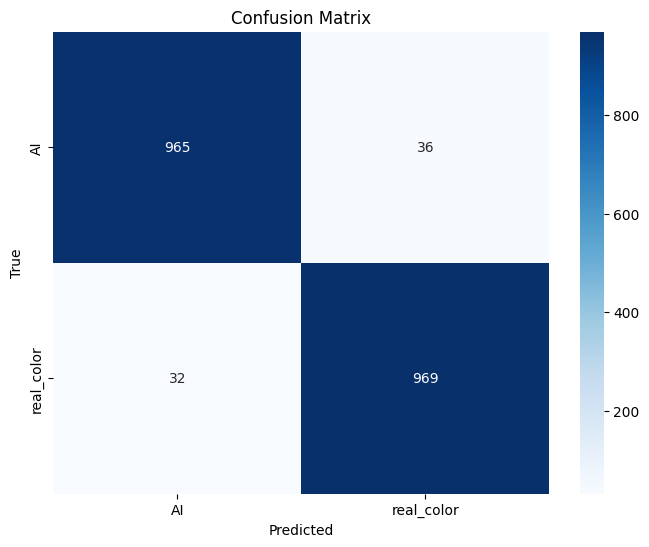

In [ ]:
# Ensure the model is in evaluation mode and on the correct device
net.eval()
all_labels = []
all_predictions = []

# Disable gradient calculation for efficiency during evaluation
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()